In [ ]:
!pip install tensorflow
!pip install pyarrow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Use pd.read_parquet instead of pd.read_csv to read Parquet files
df = pd.read_parquet('/content/train-00000-of-00001.parquet')

df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [ ]:
# checking dataset description
df.describe()

,label
count,416809.000000
mean,1.554271
std,1.490453
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [ ]:
review = []

# Get a list of column names in your DataFrame
column_names = df.columns.tolist()
print(f"Column names in DataFrame: {column_names}")

# Use the actual column name containing the text data (e.g., 'text')
# Check the output of the print statement to verify the column name.
sentences = list(df['text'])

for sen in sentences:
    review.append(sen)

Column names in DataFrame: ['text', 'label']


In [ ]:
# Accessing the correct column name 'label' instead of 'sentiment'
labels = df['label']
labels = np.array(list(map(lambda x: 1 if x=="positive" else 0, labels)))

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(review, labels, test_size=0.2)

# Convert train_sentences and test_sentences to NumPy arrays
train_sentences = np.array(train_sentences)
test_sentences = np.array(test_sentences)

print(train_sentences.shape, test_sentences.shape)

(333447,) (83362,)


In [ ]:
# parametros
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
# initilialize the tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token=oov_tok)
# Convert any potential float values (like NaN) to strings before fitting
train_sentences = [str(sentence) for sentence in train_sentences]
tokenizer.fit_on_texts(train_sentences)

# generate the word index dictionary for the training  sentences
# (This line was redundant, as fit_on_texts is already called above)
#tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad training sequences
training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the test sequences
# Convert any potential float values (like NaN) to strings before processing
test_sentences = [str(sentence) for sentence in test_sentences]
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# build the model
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Build the model explicitly
model.build(input_shape=(None, max_length))  # Replace 'None' with batch size if known

# setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,009 (1.08 MB)

 Trainable params: 283,009 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train the model with early stopping
num_epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(training_padded,
                    train_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),
                    callbacks=[early_stopping])

Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 1.0000 - loss: 4.1039e-11 - val_accuracy: 1.0000 - val_loss: 1.5939e-09
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 1.0000 - loss: 4.9157e-12 - val_accuracy: 1.0000 - val_loss: 1.2142e-09
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 1.0000 - loss: 5.8116e-12 - val_accuracy: 1.0000 - val_loss: 9.9887e-10
Epoch 4/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 1.0000 - loss: 7.7618e-12 - val_accuracy: 1.0000 - val_loss: 8.5738e-10
Epoch 5/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 1.0000 - loss: 1.0546e-11 - val_accuracy: 1.0000 - val_loss: 7.5601e-10
Epoch 6/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 1.0000 - loss: 9.4156e-12 - val_accuracy: 1.0000 - val_loss: 6.7897e-10
Epoch 7/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 1.0000 - loss: 2.3305e-12 - val_accuracy: 1.0000 - val_loss: 6.1837e-10
Epoch 8/10
10

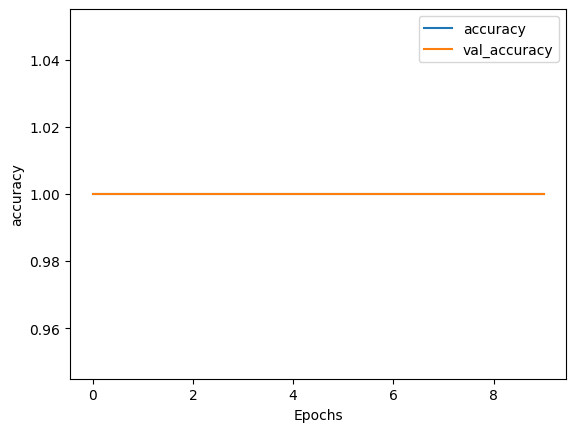

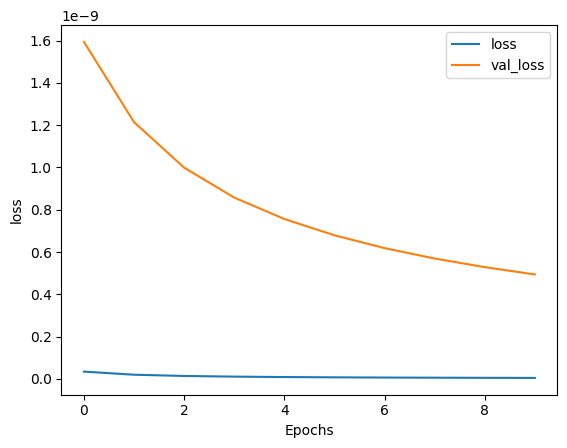

In [ ]:
# Graficar el historial de entrenamiento
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(testing_padded)

# generar metricas, recall, precision, R2
print(classification_report(test_labels, y_pred.round()))

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83362

    accuracy                           1.00     83362
   macro avg       1.00      1.00      1.00     83362
weighted avg       1.00      1.00      1.00     83362



In [ ]:
# generar matriz de confusion
cm = confusion_matrix(test_labels, y_pred.round())
print(cm)

# Grafico matriz de confusion

[[83362]]


Aplicando el Ejercicio pdf 3

In [ ]:
# build the model
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Build the model explicitly
model.build(input_shape=(None, max_length))  # Replace 'None' with batch size if known

# setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 120, 64)             │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,357 (755.30 KB)

 Trainable params: 193,357 (755.30 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# train the model with early stopping
num_epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(training_padded,
                    train_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),
                    callbacks=[early_stopping])

Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1145s 109ms/step - accuracy: 0.9991 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 9.3729e-08
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1165s 110ms/step - accuracy: 1.0000 - loss: 3.8677e-08 - val_accuracy: 1.0000 - val_loss: 5.5532e-10
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1136s 109ms/step - accuracy: 1.0000 - loss: 2.8258e-10 - val_accuracy: 1.0000 - val_loss: 3.9409e-11
Epoch 4/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1137s 109ms/step - accuracy: 1.0000 - loss: 3.0588e-11 - val_accuracy: 1.0000 - val_loss: 1.6301e-11
Epoch 5/10
 8014/10421 ━━━━━━━━━━━━━━━━━━━━ 4:07 103ms/step - accuracy: 1.0000 - loss: 1.4735e-11

KeyboardInterrupt: 

In [ ]:
# Graficar el historial de entrenamiento

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(testing_padded)

# generar metricas, recall, precision, R2
print(classification_report(test_labels, y_pred.round()))

In [ ]:
# generar matriz de confusion
cm = confusion_matrix(test_labels, y_pred.round())
print(cm)

# Grafico matriz de confusion